In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import vizlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import lasagne
import nolearn.lasagne
from lasagne.layers import *
import theano
import theano.tensor as T
from sklearn.metrics import confusion_matrix
import nolearn.lasagne.visualize

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (12.0, 8.0)

Using gpu device 0: Quadro K1000M (CNMeM is disabled, CuDNN not available)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Couldn't import dot_parser, loading of dot files will not be possible.


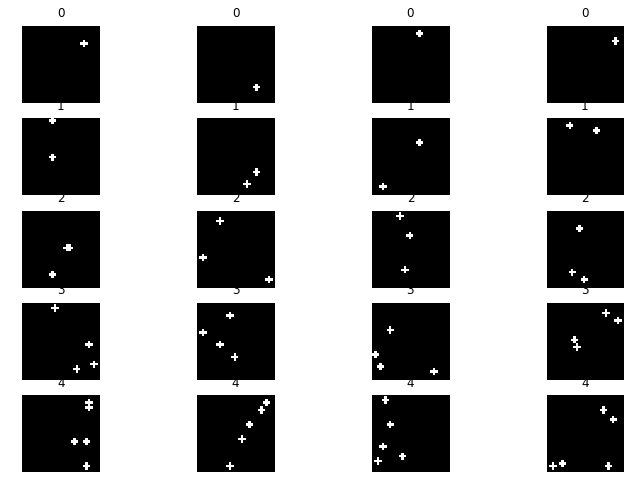

In [10]:
ds = vizlib.data.counting_2d(size=(32,32), n_examples=10000, min_spots=1, max_spots=5, seed=42, standardization_type='global').standardize('global').show_sample()

In [11]:
# I used individual standardization before,
# now I used global standardization.
# This means that all spots have the same intensity,
# irregardless of the number of spots in the image.

In [75]:
# Let's build a spot recognizer manually.
# We need a unit that outputs 1 whenever it seems a spot.
#
# We need:
# 1 * x1 + b1 > 1 * x2 + b2
# 2 * x2 + b2 > 2 * x1 + b1
# => x2 > x1 + .5 * (b1 - b2)
#    x2 < x1 + (b1 - b2)
# ==> x2 = x1 + .75 * (b1 - b2)
#
# 2 * x2 + b2 > 2 * x3 + b3
# 3 * x3 + b3 > 3 * x2 + b2
# => x3 < x2 + .5 (b2 - b3)
#    x3 > x2 + 1/3 (b2 - b3)
# 
# fix b_i = b_{i-1} - 1
#
# Conclusion:
# x_i = x_{i-1} + 1 / (i - .5) * (b_{i-1} - b_{i-1} + 1) = x_{i-1} + 1 / (i - .5)
#
# where x_1 and b_1 are free variables, for which we can pick what we want.
#
# Above analysis uses x1 as 0th term. Instead we need x0 as 0th term.
# New conclusion:
# x_i = x_{i-1} + 1 / (i - .5) * (b_{i-1} - b_{i-1} + 1) = x_{i-1} + 1 / (i - .5)

In [76]:
Wc = np.array([[0,1,0],
               [1,1,1],
               [0,1,0]], dtype=theano.config.floatX).reshape(1,1,3,3)
# only complete overlap should trigger
bc = np.array([-ds.X.max() * (Wc.sum() - .5)], dtype=theano.config.floatX)
Wd = np.ones((32 * 32, 5), dtype=theano.config.floatX)

for i in range(1, 5):
    Wd[:, i] = Wd[:, i-1] + 1 / (i + 0.5)
bd = np.array([5, 4, 3, 2, 1], dtype=theano.config.floatX)

il = InputLayer((None, 1, 32, 32))
cl = Conv2DLayer(il, pad='same', num_filters=1, filter_size=(3,3), 
                 W=Wc, nonlinearity=lasagne.nonlinearities.sigmoid, b=bc)
dl = DenseLayer(cl, num_units=5, W=Wd, b=bd, nonlinearity=lasagne.nonlinearities.softmax)

In [77]:
nn = nolearn.lasagne.NeuralNet(dl, verbose=1, update_learning_rate=1e-2, update_momentum=0.9)
nn.initialize()

In [78]:
(nn.predict(ds.X) == ds.y).mean()

1.0

# Next Steps

We now have a perfect network. In constructing this we have shown that it is indeed possible to represent this task perfectly. We also have a good idea of what the network is doing. How does this compare w/ the output of the different visualization methods?

- How can we arrive at a similar weight configuration using gradient descent?
    * Not necessarily the case that we can not already, since I used a differently standardized dataset.

<matplotlib.colorbar.Colorbar instance at 0x7fed24749248>

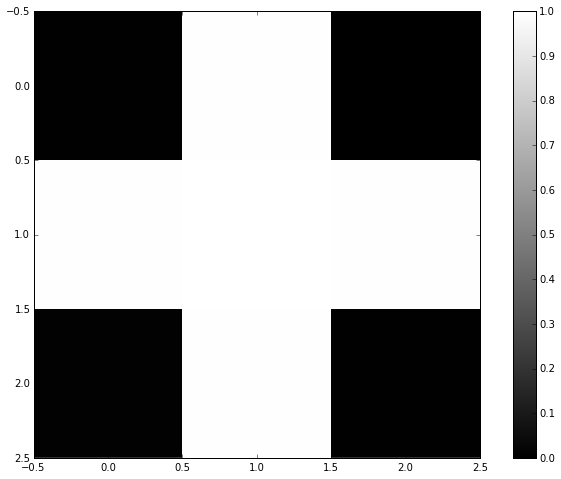

In [81]:
# Looking at the network filters.
plt.imshow(cl.W.get_value().squeeze()[::-1, ::-1])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fed14ba43b0>

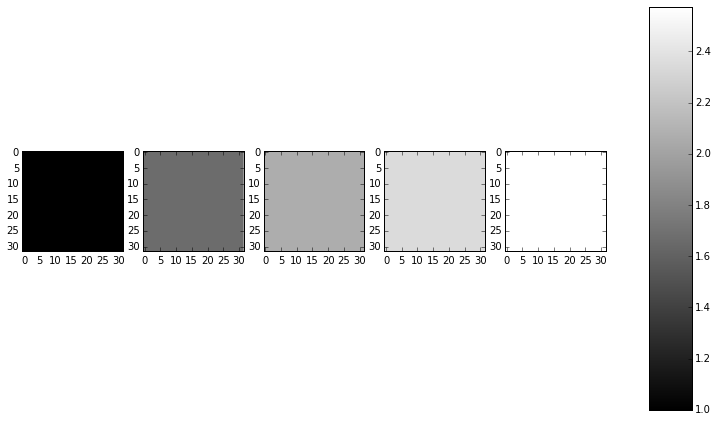

In [94]:
vmin, vmax = dl.W.get_value().min(), dl.W.get_value().max()
fig, axes = plt.subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes.flat):
    im = ax.imshow(dl.W.get_value()[:, i].reshape(32, 32), vmin=vmin, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

<matplotlib.colorbar.Colorbar instance at 0x7fed13e35440>

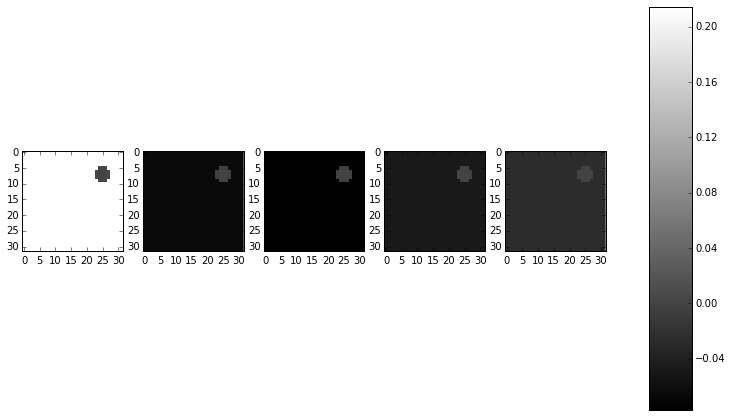

In [105]:
x = ds.X[0:1]
maps = np.array([vizlib.class_saliency_map.occlusion(x, dl, i, square_length=3) for i in range(5)])
vmin, vmax = maps.min(), maps.max()
fig, axes = plt.subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes.flat):
    im = ax.imshow(maps[i], vmin=vmin, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

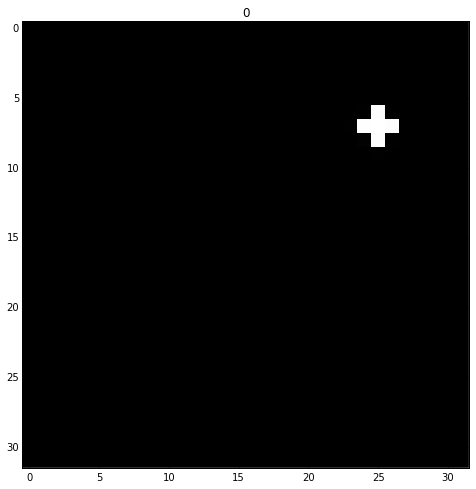

In [109]:
# The maps are saliency maps. This means that a higher value at (i, j) means the pixel (i, j) is more important.
# I see here that S[spot] is small for class 0. This suggests that the spot is not important for class 0 at all.
plt.imshow(ds.X[0:1].squeeze())
plt.title(ds.y[0])

In [113]:
# Here we see that an input of all 0s leads to a higher class output than an input with a single spot in it.
# My hypothesis is that this is because having the spot there works
# more in favor of other classes (relatively speaking).
# If this is the case, the same should not occur when we do not use a softmax output.
(nn.predict_proba(np.zeros((1,1,32,32), dtype=theano.config.floatX)),
 nn.predict_proba(ds.X[0:1]))

(array([[ 0.6364,  0.2341,  0.0861,  0.0317,  0.0117]], dtype=float32),
 array([[ 0.4219,  0.2991,  0.1631,  0.0795,  0.0364]], dtype=float32))

In [116]:
# Which is confirmed here.
# We see that the activation for class 0 does shrink when the spot is removed, 
# but that the activations of other classes shrink more.
dl.nonlinearity = lasagne.nonlinearities.identity
nn = nolearn.lasagne.NeuralNet(dl, verbose=1, update_learning_rate=1e-2, update_momentum=0.9)
nn.initialize()
(nn.predict_proba(np.zeros((1,1,32,32), dtype=theano.config.floatX)),
 nn.predict_proba(ds.X[0:1]))

(array([[ 5.,  4.,  3.,  2.,  1.]], dtype=float32),
 array([[ 5.9841,  5.6402,  5.0338,  4.315 ,  3.5337]], dtype=float32))

In [117]:
dl.nonlinearity = lasagne.nonlinearities.softmax
nn = nolearn.lasagne.NeuralNet(dl, verbose=1, update_learning_rate=1e-2, update_momentum=0.9)
nn.initialize()

<matplotlib.colorbar.Colorbar instance at 0x7fed15278a28>

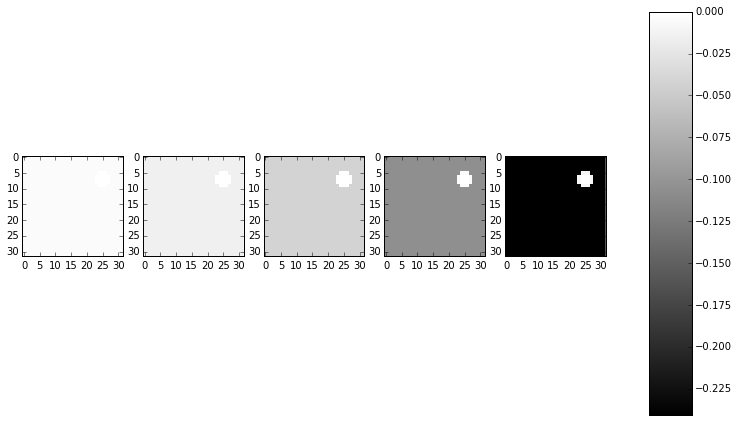

In [118]:
# Let's repeat the same experiment, but this time with sigmoidal activation function
# => hypothesis confirmed.
dl.nonlinearity = lasagne.nonlinearities.sigmoid
x = ds.X[0:1]
maps = np.array([vizlib.class_saliency_map.occlusion(x, dl, i, square_length=3) for i in range(5)])
vmin, vmax = maps.min(), maps.max()
fig, axes = plt.subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes.flat):
    im = ax.imshow(maps[i], vmin=vmin, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

<matplotlib.colorbar.Colorbar instance at 0x7fed13da8f80>

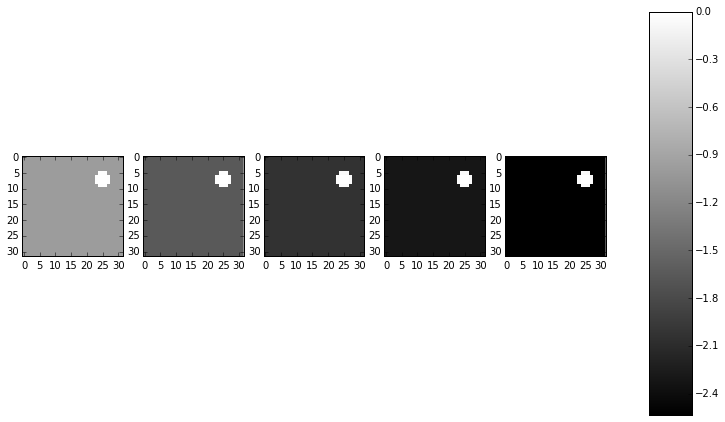

In [120]:
# Alternatively there is the identity function (i.e., no activation),
# which gives a similar result. Just different proportions.
# Q: how to decide which activation function is preferred?
dl.nonlinearity = lasagne.nonlinearities.identity
x = ds.X[0:1]
maps = np.array([vizlib.class_saliency_map.occlusion(x, dl, i, square_length=3) for i in range(5)])
vmin, vmax = maps.min(), maps.max()
fig, axes = plt.subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes.flat):
    im = ax.imshow(maps[i], vmin=vmin, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

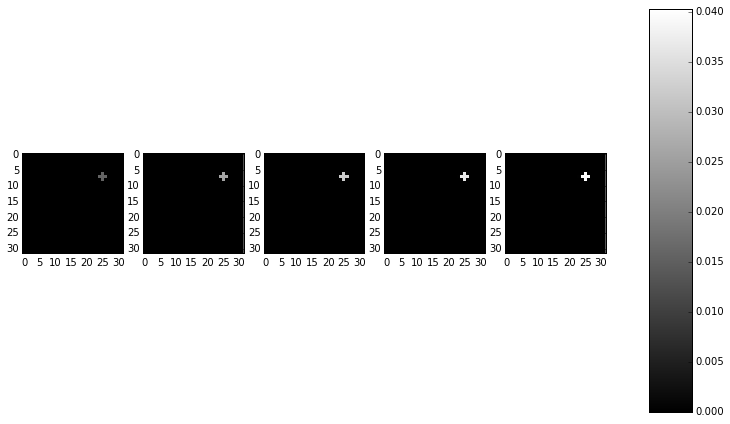

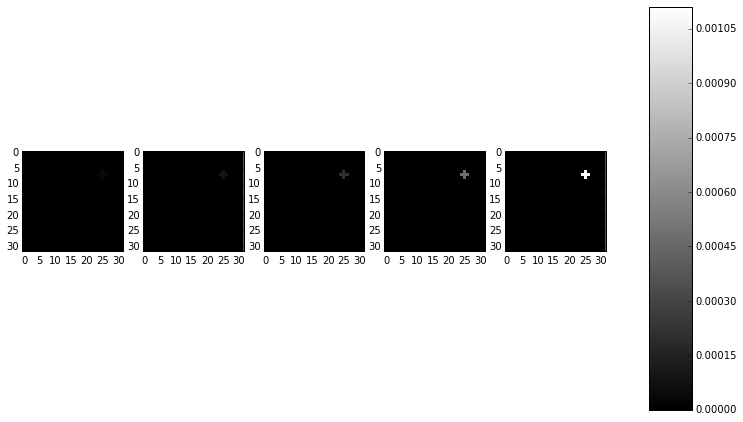

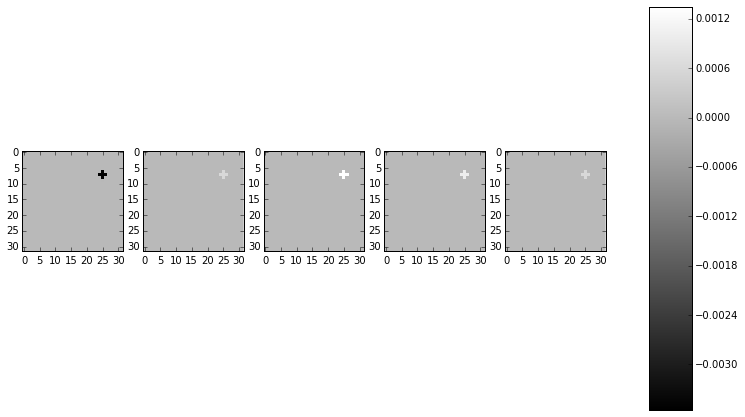

In [124]:
# What about the Taylor Series Expansion method?
# It gives similar results to the occlusion method.
# For the identity activation the spot is very important,
# for the sigmoid it is negligible, 
# and for the softmax it is negatively important.
nonlinearities = (lasagne.nonlinearities.identity, lasagne.nonlinearities.sigmoid, lasagne.nonlinearities.softmax)
for nl in nonlinearities:
    dl.nonlinearity = nl
    x = ds.X[0:1]
    maps = np.array([vizlib.class_saliency_map.taylor_expansion(x, dl, i, ignore_nonlinearity=False) for i in range(5)])
    vmin, vmax = maps.min(), maps.max()
    fig, axes = plt.subplots(nrows=1, ncols=5)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(maps[i], vmin=vmin, vmax=vmax)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

# Activation Maximization

In [148]:
X_init = np.random.randn(1, 1, 32, 32).astype(theano.config.floatX)
#X_init = ds.X.mean(axis=0).reshape(1, 1, 32, 32)

histories, scores_and_maximizers = vizlib.activation_maximization.maximize_scores(
    dl,
    X_init,
    number_of_iterations=100,
    ignore_nonlinearity=True,
    output_node=None,
    learning_rate=0.01,
    momentum=0.9,
    max_norm=None,
)
scores, maximizers = zip(*scores_and_maximizers)
maximizers = np.array(maximizers)

<matplotlib.colorbar.Colorbar instance at 0x7fed0f230368>

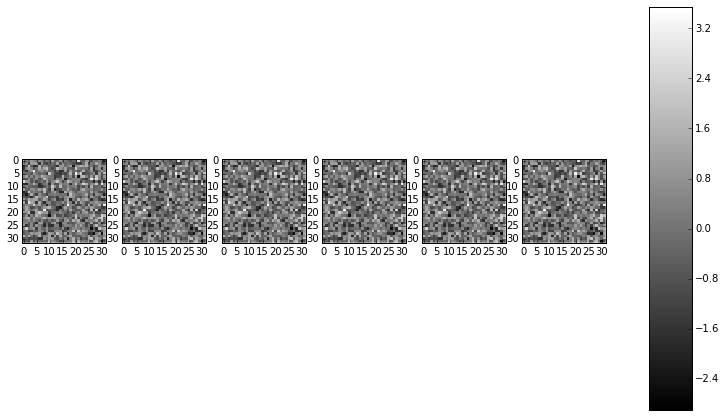

In [149]:
vmin, vmax = maximizers.min(), maximizers.max()
fig, axes = plt.subplots(nrows=1, ncols=6)
axes[0].imshow(X_init.squeeze())
for i, ax in enumerate(axes.flatten()[1:]):
    im = ax.imshow(maximizers[i].squeeze(), vmin=vmin, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

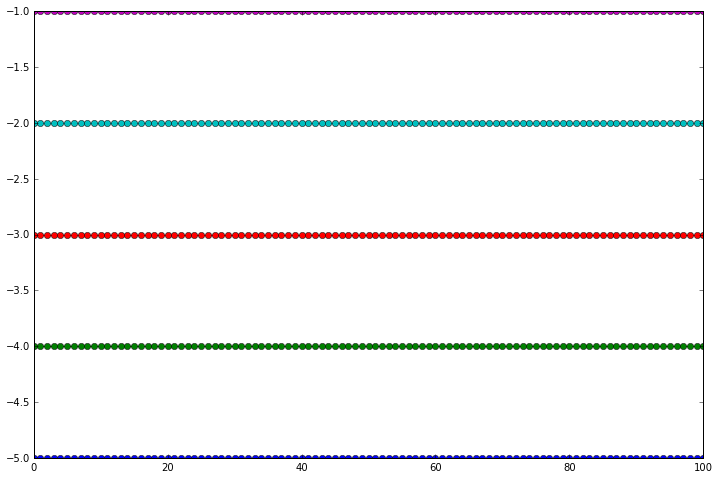

In [150]:
plt.figure()
plt.hold('on')
for h in histories:
    plt.plot(h, 'o-')
plt.hold('off')